# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [1]:
# ! pip install git+https://github.com/openai/whisper.git dtw-python

In [63]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from IPython.display import Audio
from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the Fleurs dataset

Select the language of the Fleur dataset to download. Please note that the transcription and translation performance varies widely depending on the language. Appendix D.2 in the paper contains the performance breakdown by language.

In [3]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs", "en_us", split="validation[:10]")
dataset = dataset.rename_column("raw_transcription", "text")

/home/sanchit/hf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sanchit/datasets/src/datasets/load.py:1483: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [84]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation[:10]")

/home/sanchit/datasets/src/datasets/load.py:1483: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


# Running inference on the dataset using a medium Whisper model

The following will take a few minutes to transcribe and translate utterances in the dataset.

In [4]:
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from whisper import load_model, transcribe

model_path = hf_hub_download(repo_id="distil-whisper/distil-large-v3-openai", filename="model.bin")
model = load_model(model_path)

In [5]:
options = dict(language="en", beam_size=1, best_of=5)
transcribe_options = dict(task="transcribe", **options)

In [87]:
references = []
transcriptions = []
translations = []

for sample in dataset:
    audio = sample["audio"]["array"]
    audio = torch.from_numpy(audio).float()
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    text = sample["text"].lower()
    
    transcriptions.append(transcription)
    references.append(text)

In [88]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions))
data

reference  \
0                                                                                                                                                                                                                                                                                   mister quilter is the apostle of the middle classes and we are glad to welcome his gospel   
1                                                                                                                                                                                                                                                                                                             nor is mister quilter's manner less interesting than his matter   
2                                                                                                                                                                                                he tells us that at this festive season of the year with christmas and roast beef looming before us similes drawn from eating and its results occur most readily to the mind   
3                                                                                                                                                                                                                                       he has grave doubts whether sir frederick leighton's work is really greek after all and can discover in it but little of rocky ithaca   
4  linnell's pictures are a sort of up guards and at em paintings and mason's exquisite idylls are as national as a jingo poem mister birket foster's landscapes smile at one much in the same way that mister carker used to flash his teeth and mister john collier gives his sitter a cheerful slap on the back before he says like a shampooer in a turkish bath next man   
5                                                                                                                                                                                                                                                                it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression   
6                                                                                                                                                                                                                                                                                                  on the general principles of art mister quilter writes with equal lucidity   
7                                                                                                                                                                                                                                                                         painting he tells us is of a different quality to mathematics and finish in art is adding more fact   
8                                                                                                                                                                                                                                                                                                                   as for etchings they are of two kinds british and foreign   
9                                                                                                                 he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures makes the customary appeal to the last judgment and reminds us that in the great days of art michael angelo was the furnishing upholsterer   

                                                                                                                                                                                                                                                                                                        

# Word-level timestamps using attention weights

Below, we use the cross-attention weights to determine more granular, word-level timestamps. It uses a set of heuristics and dynamic time warping (DTW) to find the alignment between the audio and the transcript.

In [8]:
import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [9]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(multilingual=True, num_languages=100)

In [10]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []
    
    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []
    
    return words, word_tokens

In [11]:
def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []
    
    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)
    
    return words, word_tokens

In [89]:
languages = {"en_us": "English"}
lang = "en_us"

if languages[lang] in {"Chinese", "Japanese", "Thai", "Lao", "Myanmar"}:
    # These languages don't typically use spaces, so it is difficult to split words
    # without morpheme analysis. Here, we instead split words at any
    # position where the tokens are decoded as valid unicode points
    split_tokens = split_tokens_on_unicode
else:
    split_tokens = split_tokens_on_spaces

In [90]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


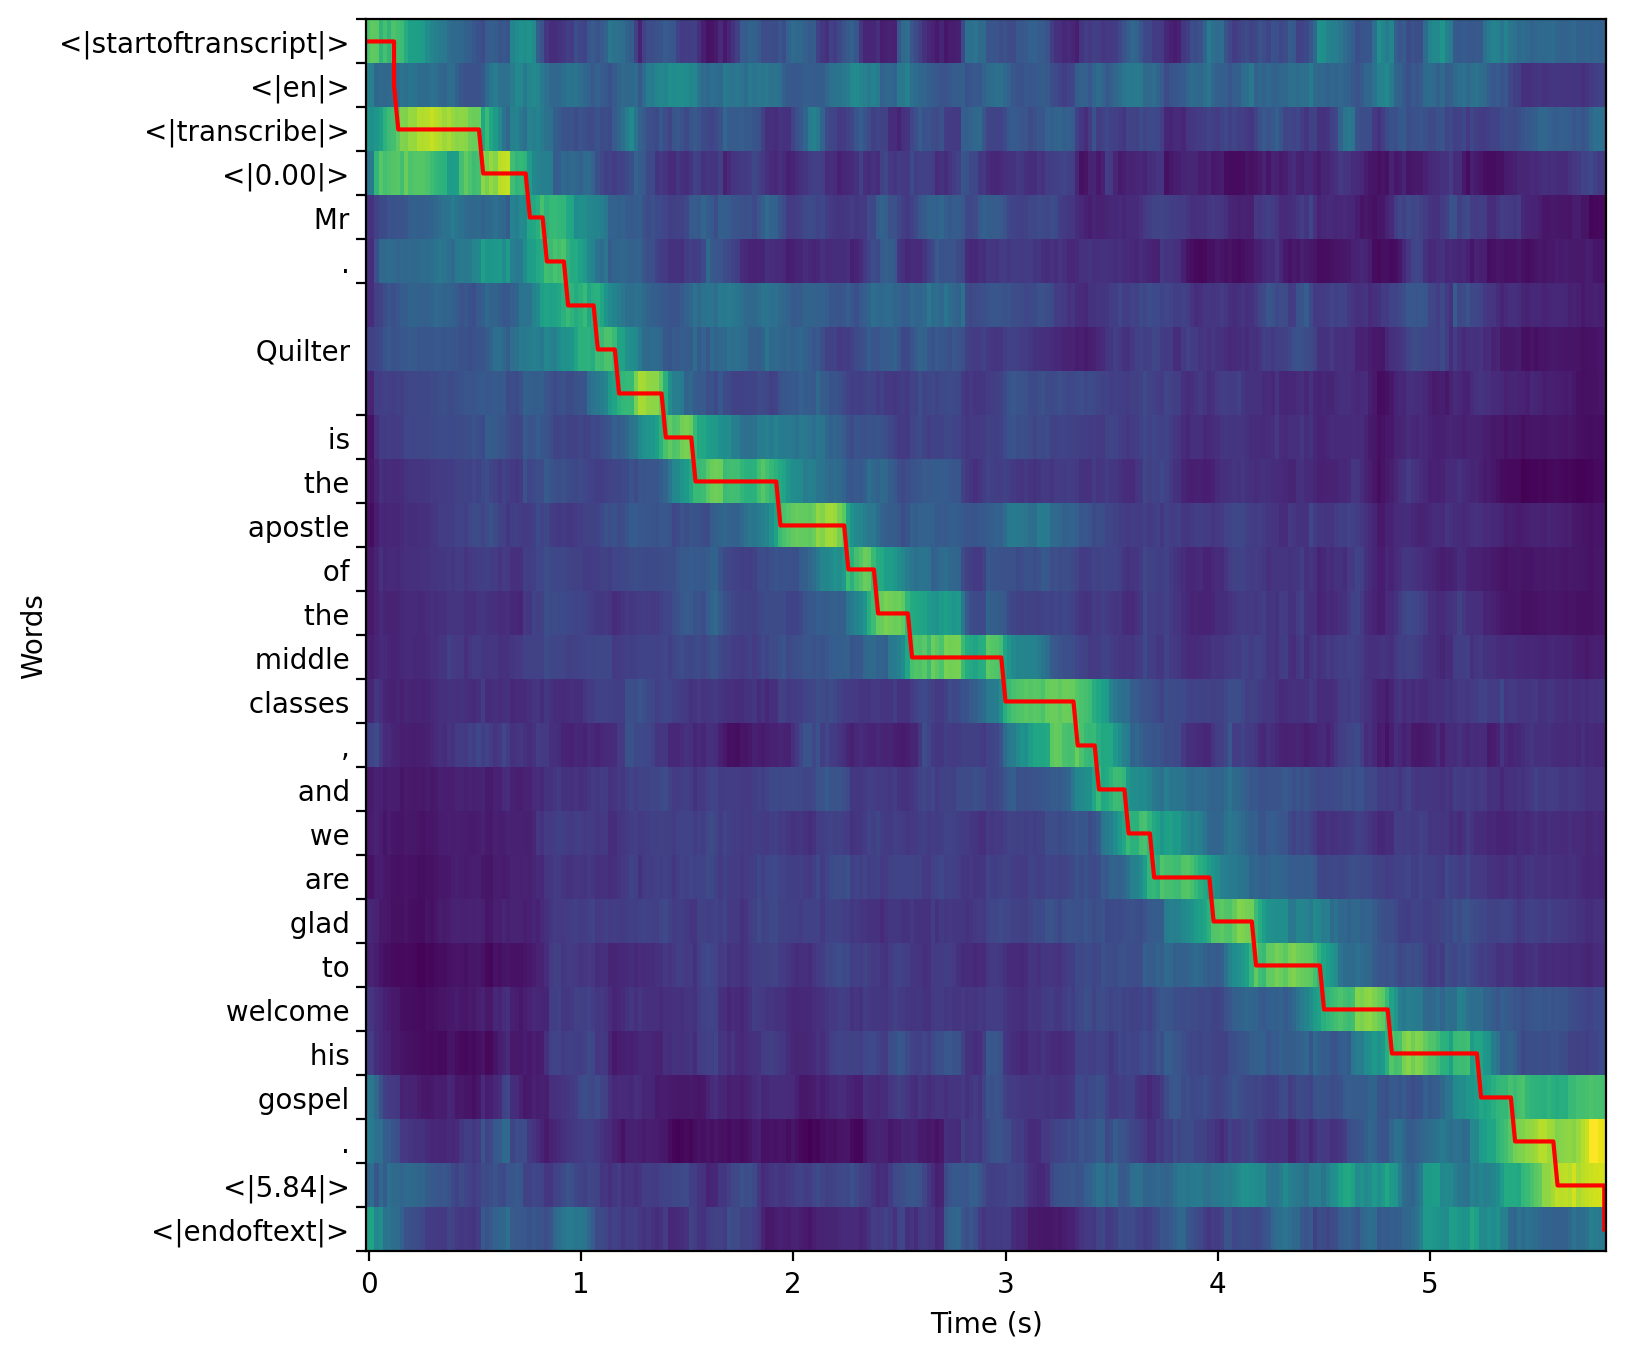

word  begin   end
0         Mr   0.76  0.84
1    Quilter   0.94  1.40
2         is   1.40  1.54
3        the   1.54  1.94
4    apostle   1.94  2.26
5         of   2.26  2.40
6        the   2.40  2.56
7     middle   2.56  3.00
8    classes   3.00  3.34
9        and   3.44  3.58
10        we   3.58  3.70
11       are   3.70  3.98
12      glad   3.98  4.18
13        to   4.18  4.50
14   welcome   4.50  4.82
15       his   4.82  5.24
16    gospel   5.24  5.40

In [92]:
# for the first 10 examples in the dataset
for batch, transcription in zip(dataset.select(range(1)), transcriptions[:1]):
    print(transcription)

    audio = batch["audio"]["array"]
    audio = torch.from_numpy(audio).float()
    label = batch["text"]
  
    duration = len(audio)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio), n_mels=128).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ).cuda()
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames    
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    # for label in ax.get_yminorticklabels():
    #     label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))

In [ ]:
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

In [95]:
model.dims.n_text_head

20

In [93]:
alignment_heads = torch.zeros(
    model.dims.n_text_layer, model.dims.n_text_head, dtype=torch.bool
)
alignment_heads[model.dims.n_text_layer // 2 :] = True
alignment_heads = alignment_heads.to_sparse()

 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


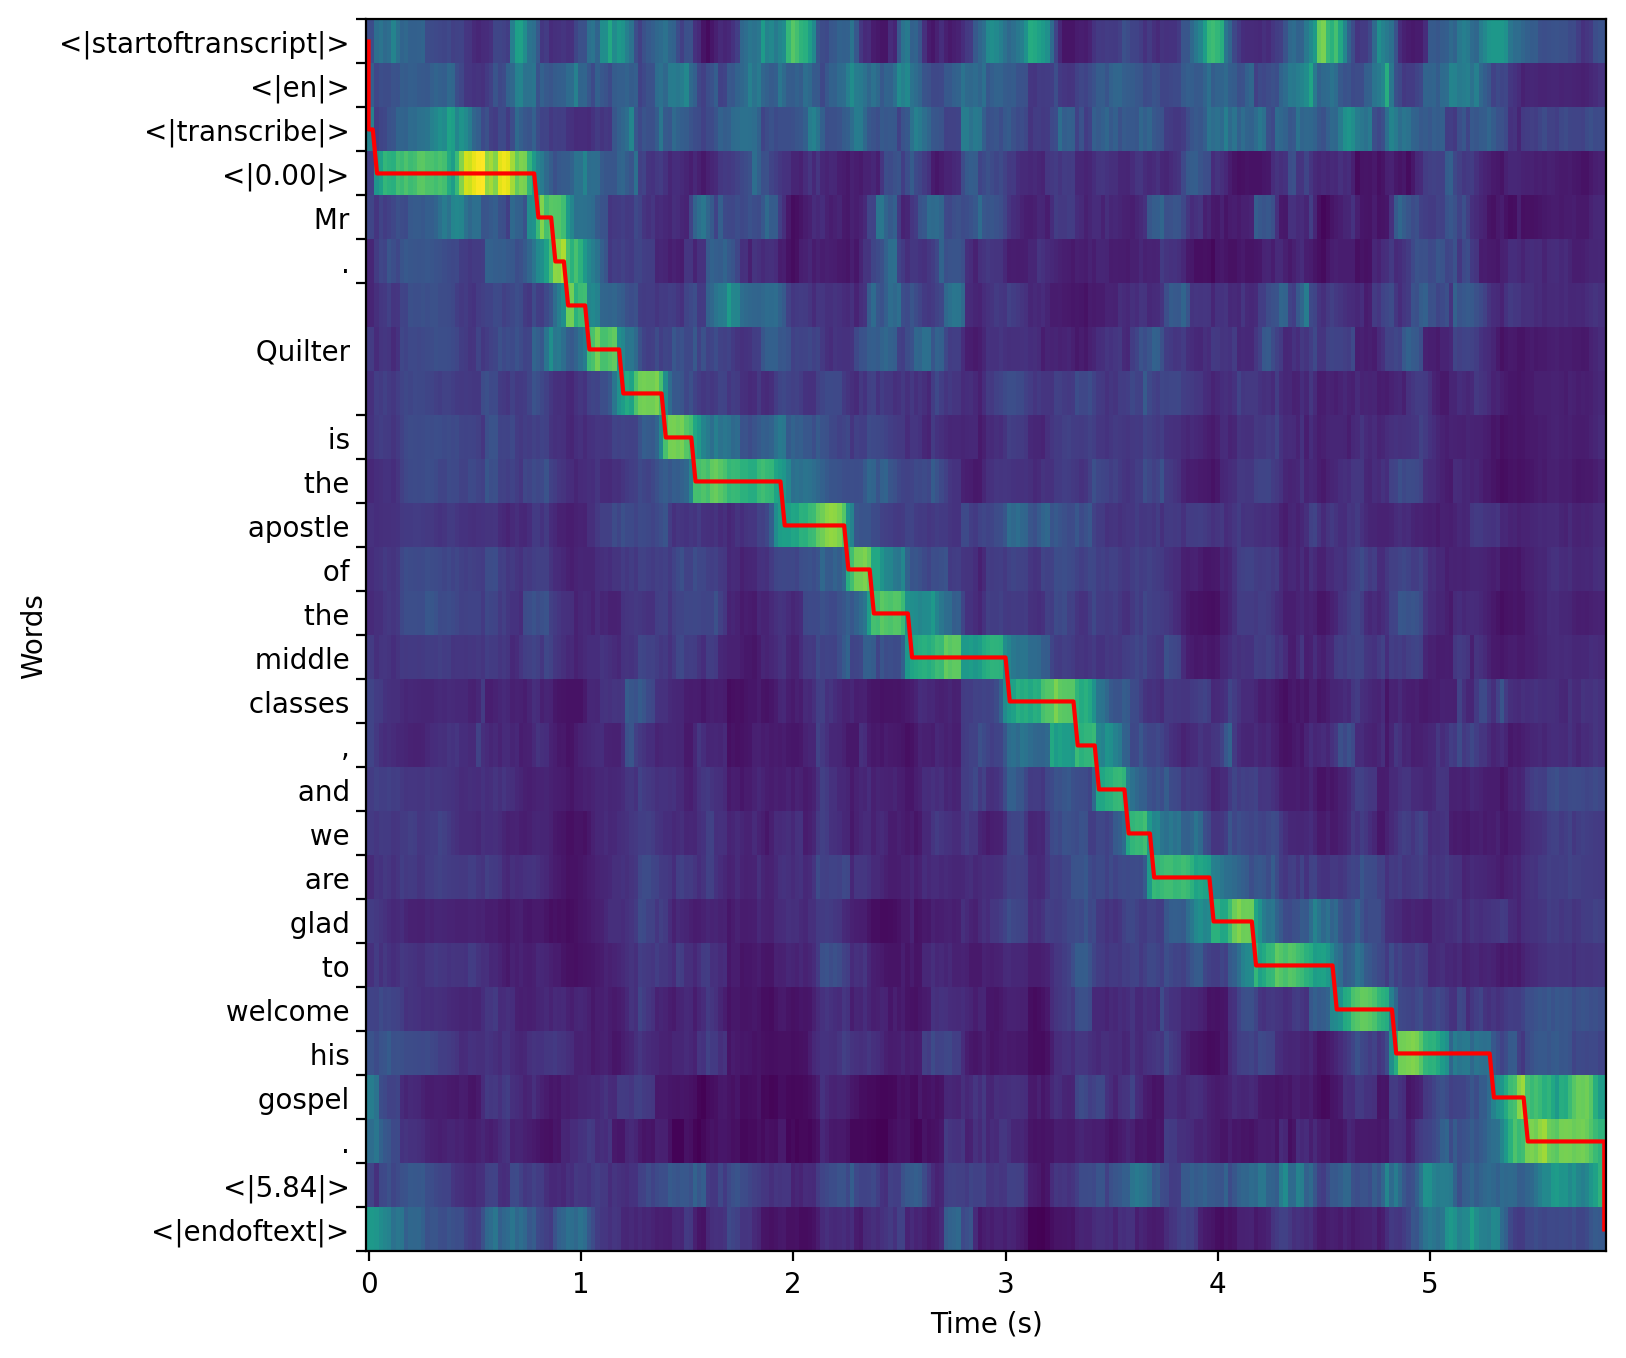

word  begin  w_begin   end  w_end
0         Mr   0.80     1.60  0.88   2.06
1    Quilter   0.94     2.30  1.40   2.36
2         is   1.40     2.40  1.54   2.62
3        the   1.54     2.66  1.96   3.12
4    apostle   1.96     3.36  2.26   3.44
5         of   2.26     3.48  2.38   3.56
6        the   2.38     3.62  2.56   3.70
7     middle   2.56     3.74  3.02   4.00
8    classes   3.02     4.10  3.34   4.18
9        and   3.44     4.68  3.58   4.80
10        we   3.58     4.90  3.70   5.34

 Nor is Mr. Quilter's manner less interesting than his matter.


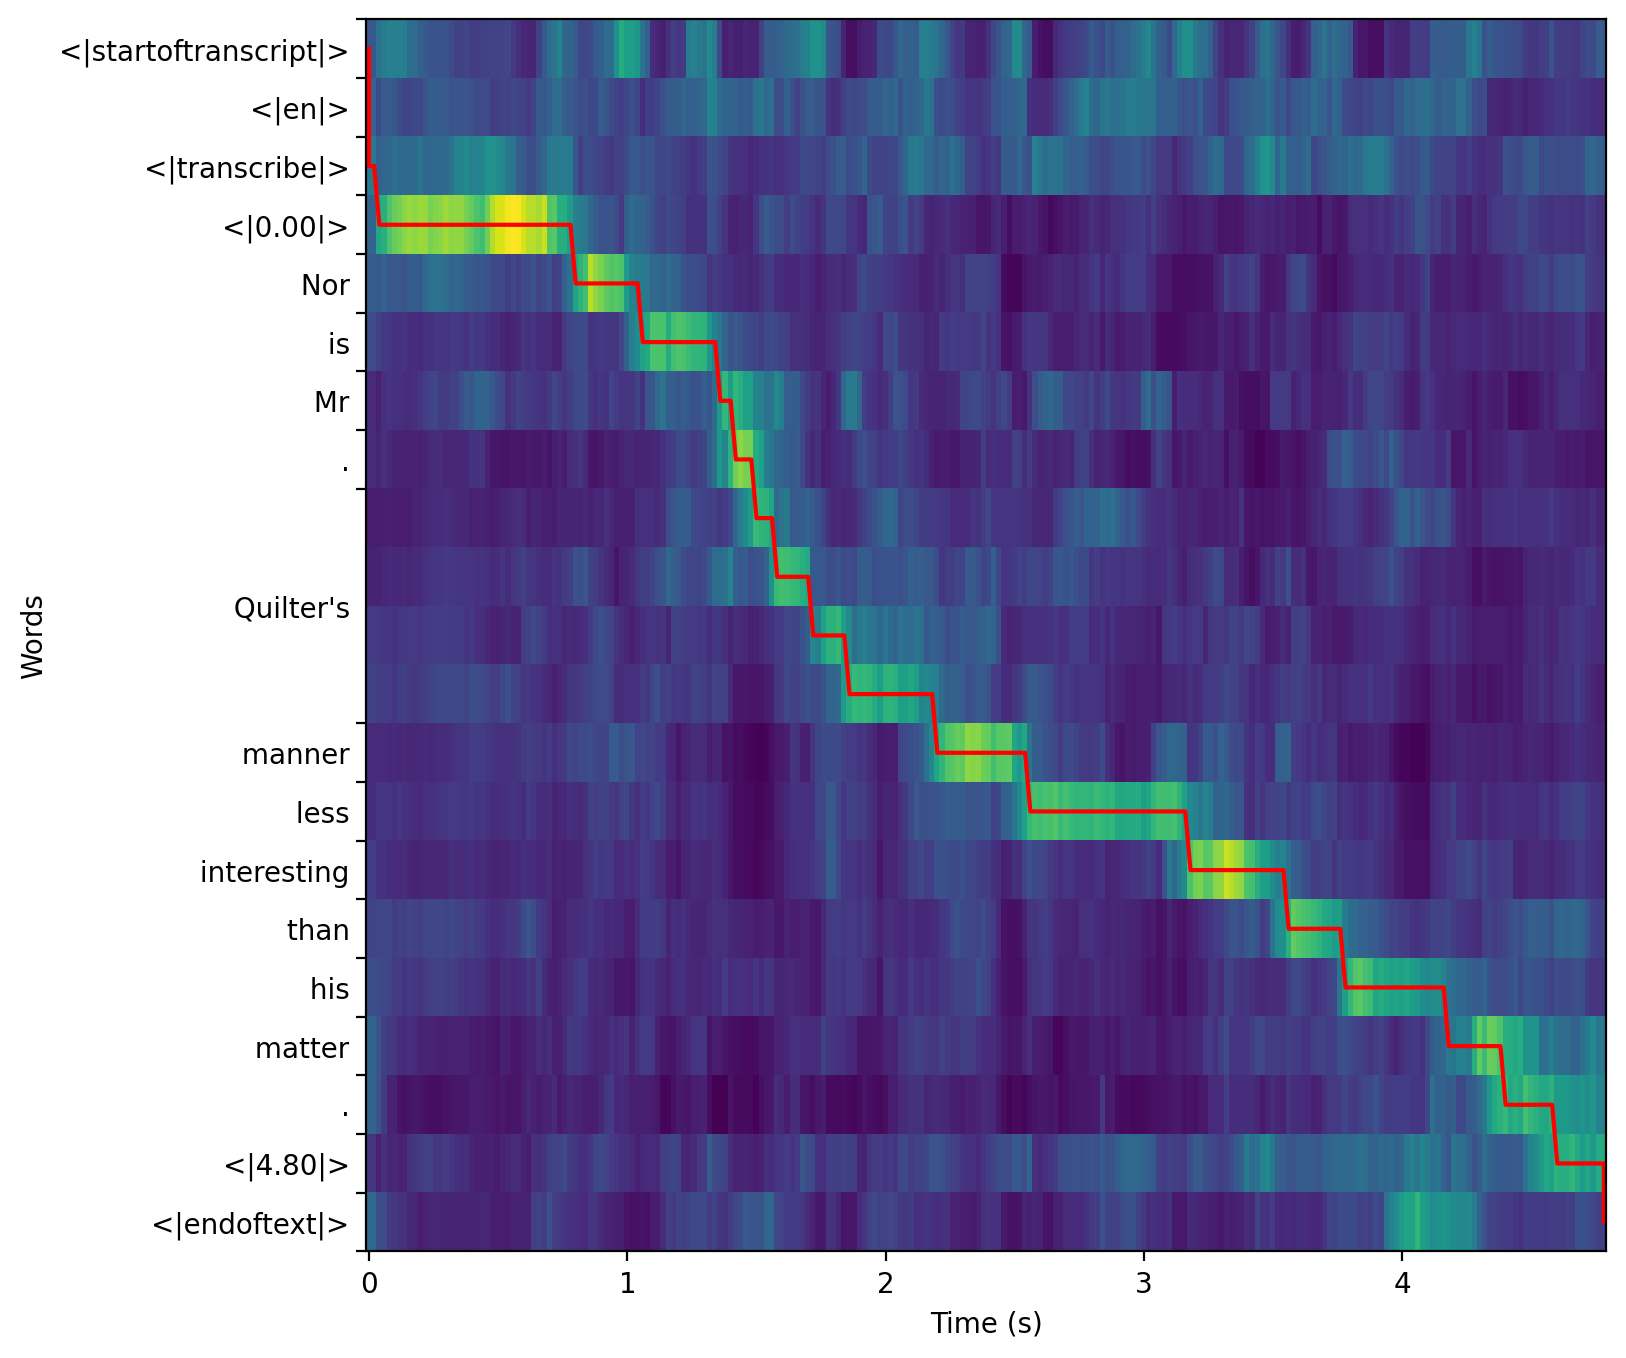

word  begin  w_begin   end  w_end
0         Nor   0.80     1.92  1.06   2.18
1          is   1.06     2.36  1.36   2.54
2          Mr   1.36     2.70  1.42   3.22
3   Quilter's   1.50     3.58  2.20   3.74
4      manner   2.20     3.96  2.56   4.26

 he tells us that at this festive season of the year with christmas and roast beef looming before us similes drawn from eating and its results occur most readily to the mind


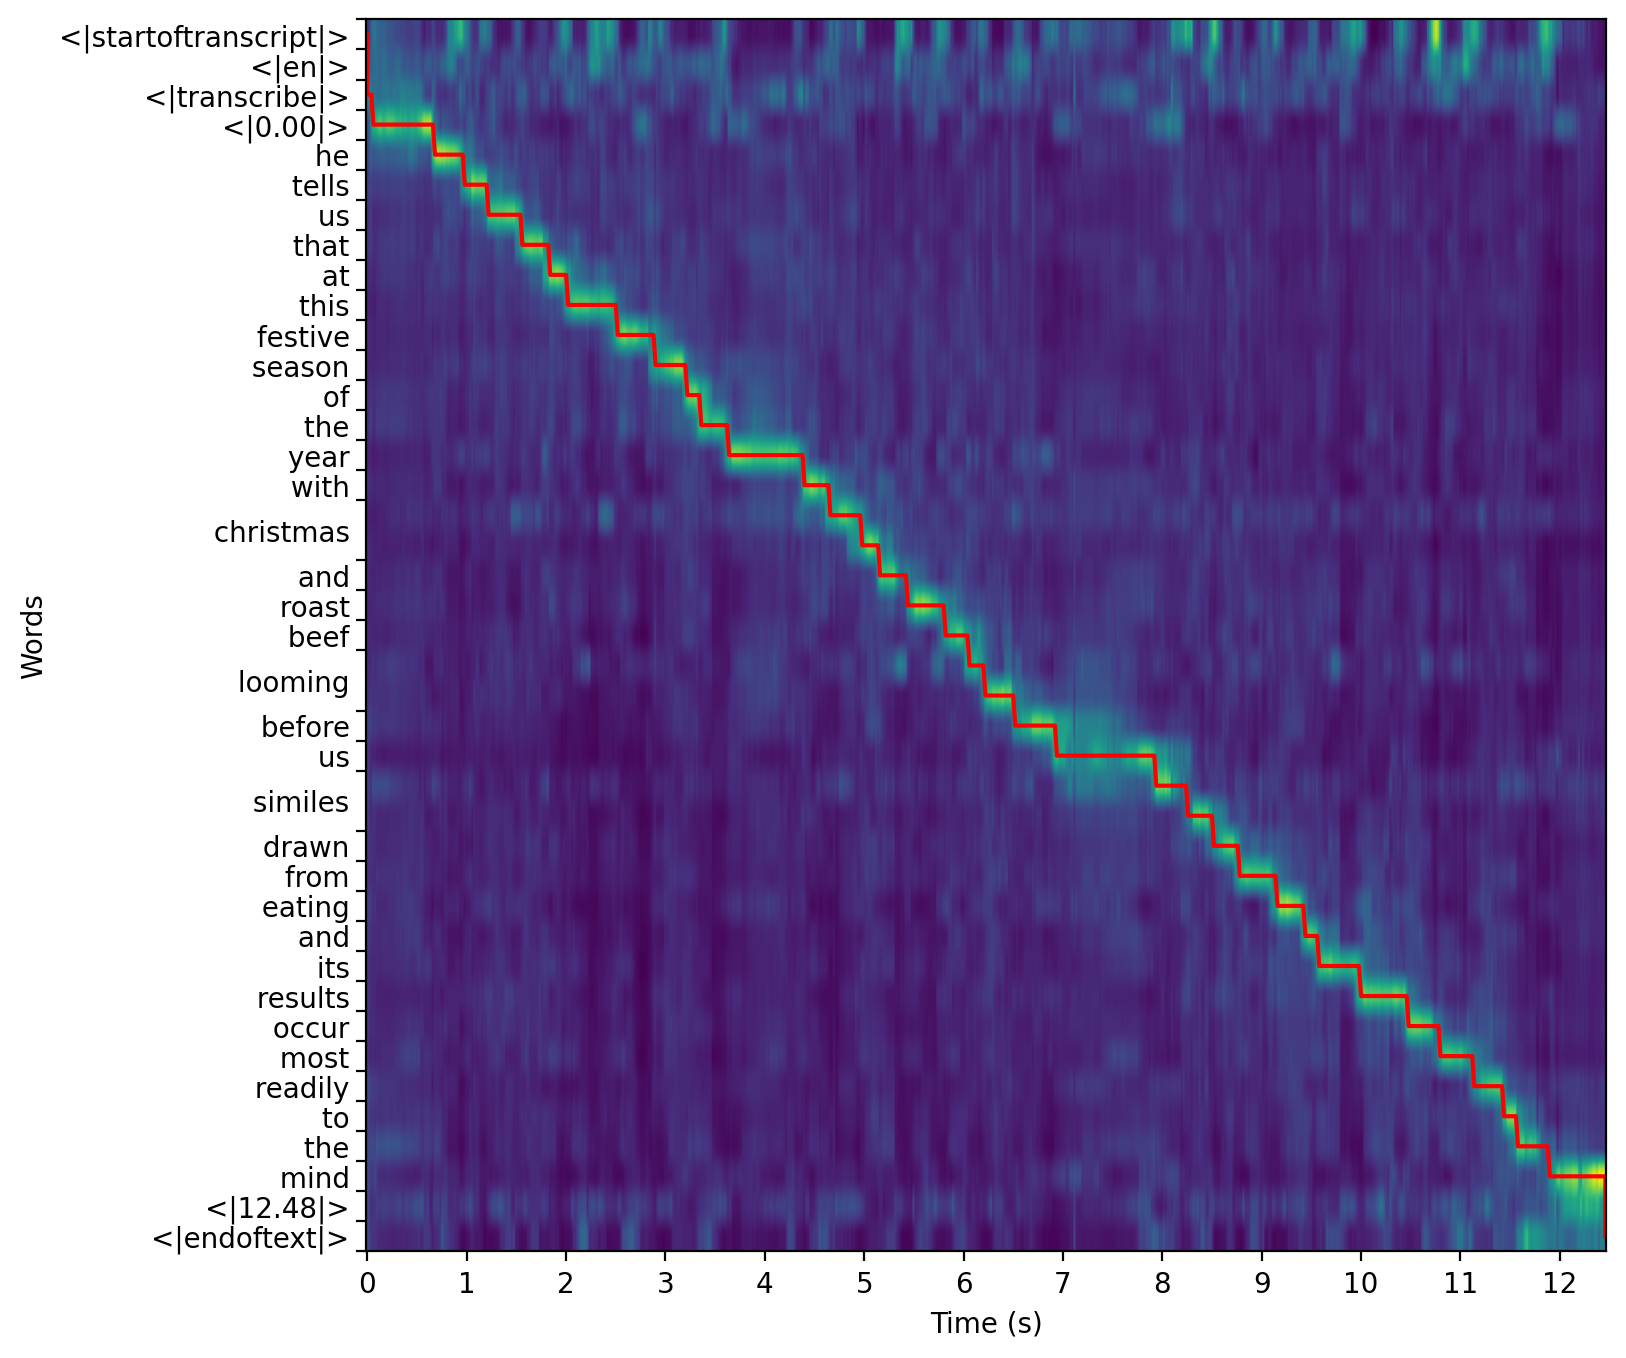

word  begin  w_begin    end  w_end
0           he   0.68     1.70   0.98   1.76
1        tells   0.98     1.82   1.22   1.98
2           us   1.22     2.12   1.56   2.52
3         that   1.56     2.60   1.84   3.00
4           at   1.84     3.12   2.02   3.16
5         this   2.02     3.24   2.52   3.32
6      festive   2.52     3.38   2.90   3.58
7       season   2.90     4.22   3.22   4.38
8           of   3.22     4.50   3.36   4.98
9          the   3.36     5.06   3.64   5.14
10        year   3.64     5.24   4.40   5.44
11        with   4.40     5.56   4.66   5.78
12   christmas   4.66     5.92   5.16   6.24
13         and   5.16     6.32   5.44   6.64
14       roast   5.44     6.76   5.82   6.84
15        beef   5.82     7.78   6.06   8.28
16     looming   6.06     8.34   6.52   8.58
17      before   6.52     8.64   6.94   8.76
18          us   6.94     8.94   7.94   9.18
19     similes   7.94     9.34   8.52   9.40
20       drawn   8.52     9.46   8.78   9.56
21        from   8.78     9.62   9.16  10.00
22      eating   9.16    10.22   9.44  10.46
23         and   9.44    10.62   9.58  10.80
24         its   9.58    10.92  10.00  11.22
25     results  10.00    11.34  10.48  11.42
26       occur  10.48    11.50  10.80  11.56
27        most  10.80    11.62  11.14  11.88

 He has grave doubts whether Sir Frederick Leighton's work is really Greek after all, and can discover in it but little of Rocky Ithaca.


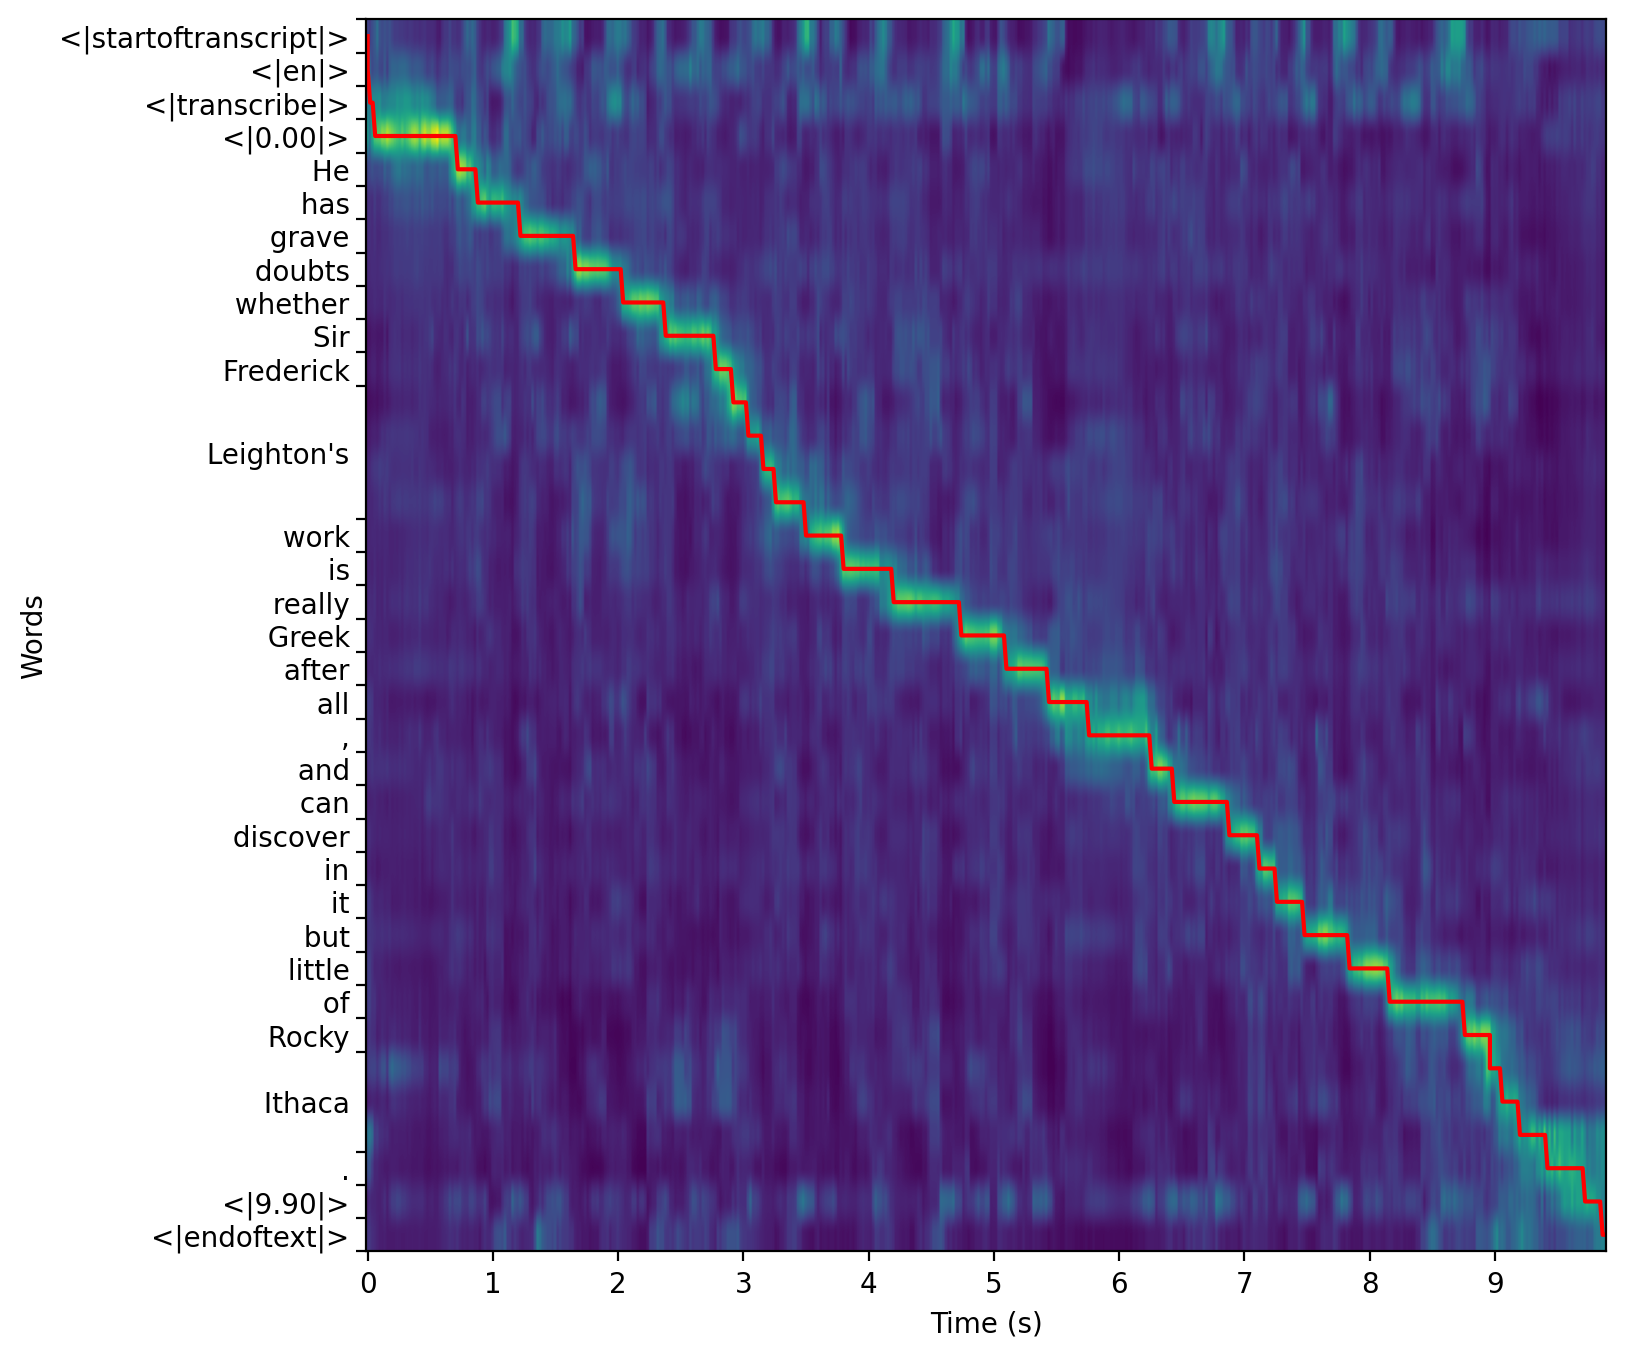

word  begin  w_begin   end  w_end
0            He   0.72     1.78  0.88   2.04
1           has   0.88     2.26  1.22   2.38
2         grave   1.22     2.44  1.66   2.76
3        doubts   1.66     2.84  2.04   3.22
4       whether   2.04     3.32  2.38   3.52
5           Sir   2.38     3.70  2.78   3.78
6     Frederick   2.78     3.92  2.92   4.16
7    Leighton's   2.92     4.44  3.50   4.70
8          work   3.50     4.92  3.80   5.12
9            is   3.80     5.34  4.20   5.44
10       really   4.20     6.16  4.74   6.24
11        Greek   4.74     6.32  5.10   6.44
12        after   5.10     6.52  5.44   6.88
13          all   5.44     7.04  5.76   7.08
14          and   6.26     7.36  6.44   7.48
15          can   6.44     7.60  6.88   7.86
16     discover   6.88     8.04  7.12   8.08
17           in   7.12     8.44  7.26   8.74
18           it   7.26     8.92  7.48   9.32

 linnel's pictures are a sort of upgards and adam paintings and mason's exquisite iddles are as national as a jingo poem mr burkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampooer and a turkish bath next man


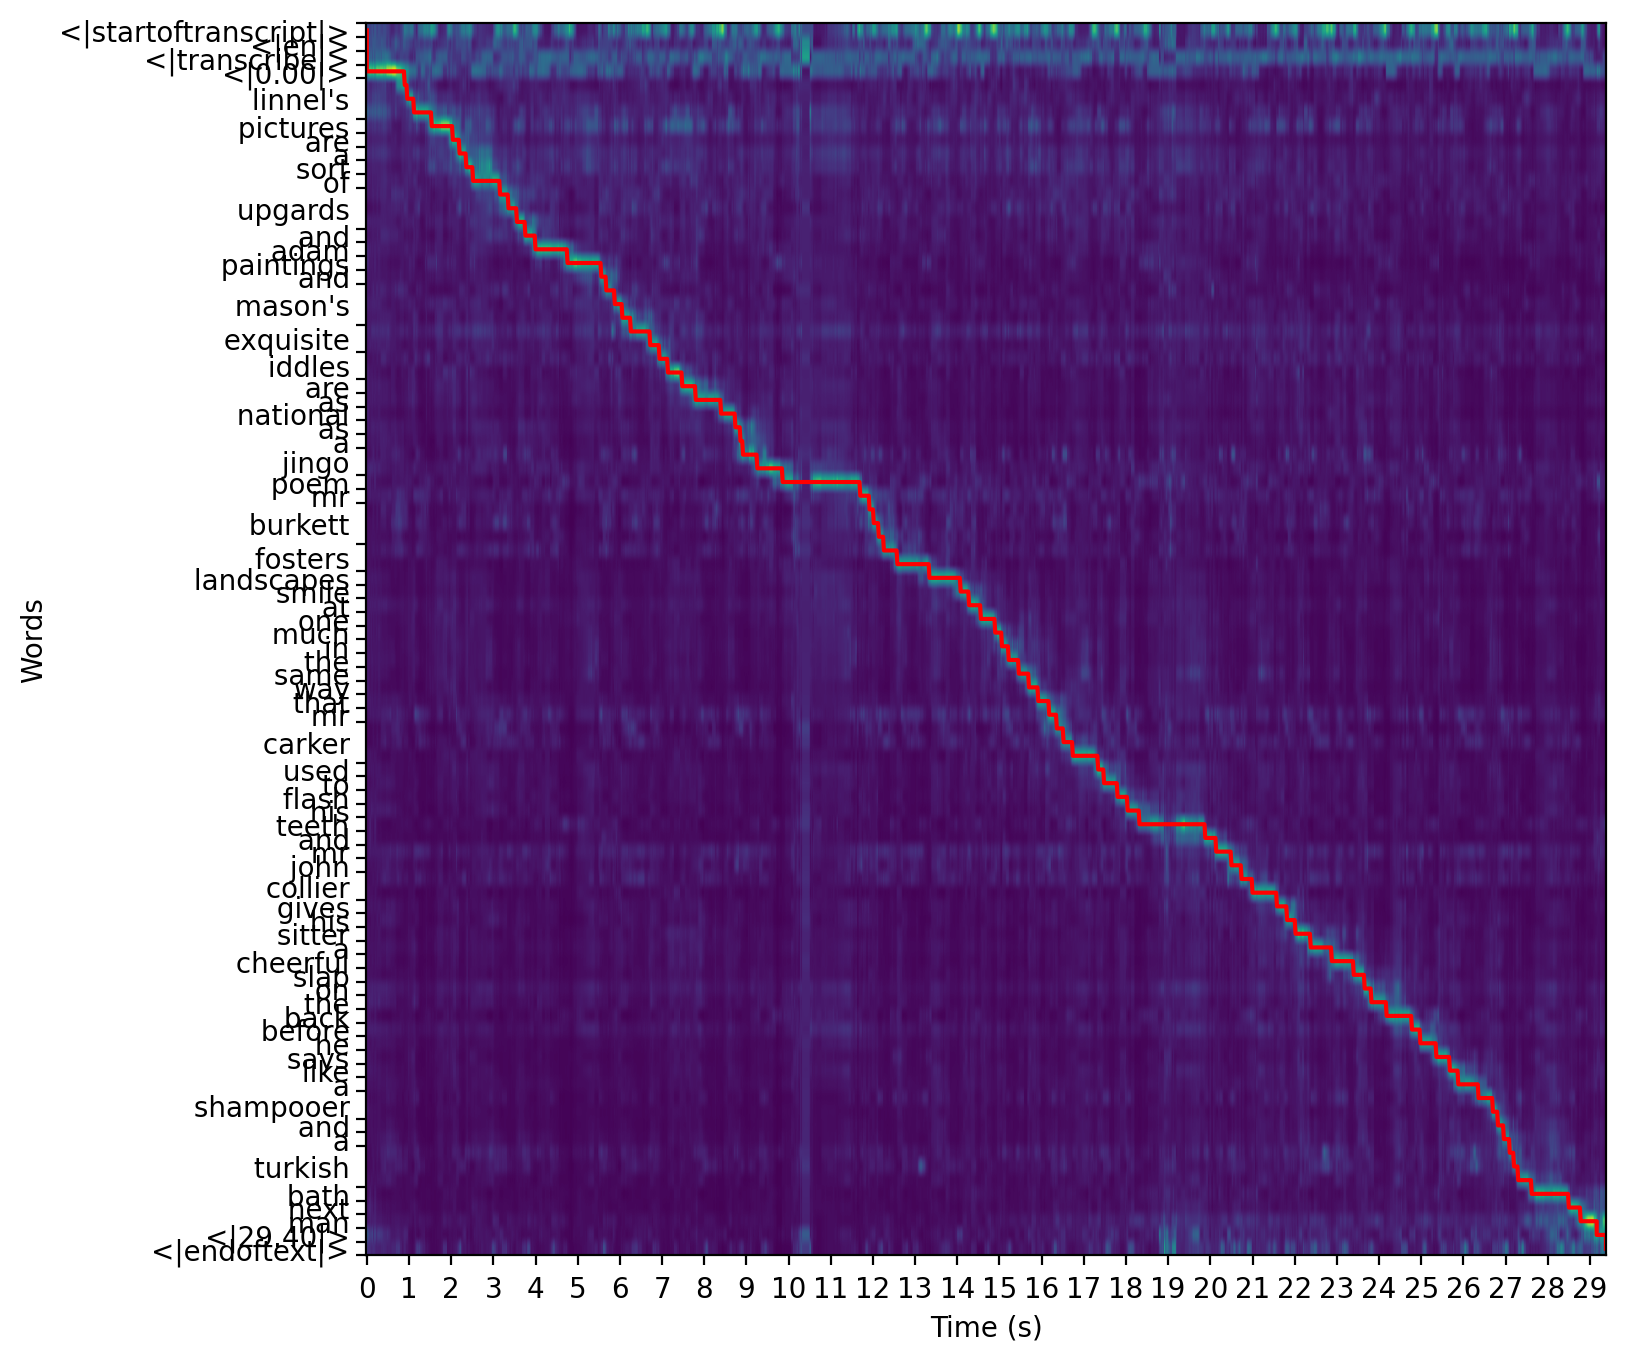

word  begin  w_begin    end  w_end
0      linnel's   0.90     2.18   1.54   2.36
1      pictures   1.54     2.42   2.04   2.46
2           are   2.04     3.06   2.20   3.12
3             a   2.20     3.26   2.36   3.58
4          sort   2.36     3.64   2.52   3.72
5            of   2.52     3.82   3.16   4.00
6       upgards   3.16     4.40   3.76   4.84
7           and   3.76     5.44   4.00   5.52
8          adam   4.00     5.58   4.76   6.00
9     paintings   4.76     6.14   5.56   6.72
10          and   5.56     6.86   5.68   7.14
11      mason's   5.68     7.40   6.26   7.50
12    exquisite   6.26     7.62   6.94   7.68
13       iddles   6.94     8.04   7.48   8.46
14          are   7.48     8.64   7.80   8.70
15           as   7.80     8.80   8.40   8.82
16     national   8.40     8.86   8.74   9.26
17           as   8.74     9.42   8.86   9.76
18            a   8.86    11.52   8.92  11.74
19        jingo   8.92    11.82   9.86  12.10
20         poem   9.86    12.18  11.70  12.66
21           mr  11.70    12.76  11.92  13.32
22      burkett  11.92    13.64  12.26  14.10
23      fosters  12.26    14.18  13.34  14.22
24   landscapes  13.34    14.46  14.08  14.56
25        smile  14.08    14.72  14.28  14.90
26           at  14.28    14.98  14.56  15.02
27          one  14.56    15.08  14.90  15.18
28         much  14.90    15.22  15.06  15.44
29           in  15.06    15.52  15.22  15.68
30          the  15.22    15.76  15.46  15.88
31         same  15.46    15.94  15.70  16.20
32          way  15.70    16.28  15.92  16.68
33         that  15.92    17.18  16.18  17.30
34           mr  16.18    17.36  16.36  17.42
35       carker  16.36    17.52  17.34  17.80
36         used  17.34    17.86  17.48  17.98
37           to  17.48    18.10  17.80  18.42
38        flash  17.80    19.80  18.04  19.88
39          his  18.04    19.94  18.32  20.16
40        teeth  18.32    20.24  19.88  20.44
41          and  19.88    20.54  20.14  20.96
42           mr  20.14    21.36  20.50  21.56
43         john  20.50    21.62  20.74  21.76
44      collier  20.74    21.80  21.58  22.08
45        gives  21.58    22.30  21.82  22.32
46          his  21.82    22.44  22.02  22.92
47       sitter  22.02    23.10  22.38  23.44
48            a  22.38    23.56  22.88  23.60
49     cheerful  22.88    23.68  23.40  23.74
50         slap  23.40    23.80  23.66  24.08
51           on  23.66    24.54  23.82  24.84
52          the  23.82    24.90  24.18  24.98
53         back  24.18    25.04  24.78  25.36
54       before  24.78    25.50  24.98  25.66
55           he  24.98    25.76  25.36  25.78
56         says  25.36    26.00  25.68  26.62
57         like  25.68    26.74  25.88  26.78
58            a  25.88    26.86  26.36  26.88
59    shampooer  26.36    26.98  26.82  27.30
60          and  26.82    27.38  26.96  27.66
61            a  26.96    28.30  27.10  28.50
62      turkish  27.10    28.58  27.62  28.82

 It is obviously unnecessary for us to point out how luminous these criticisms are, how delicate in expression.


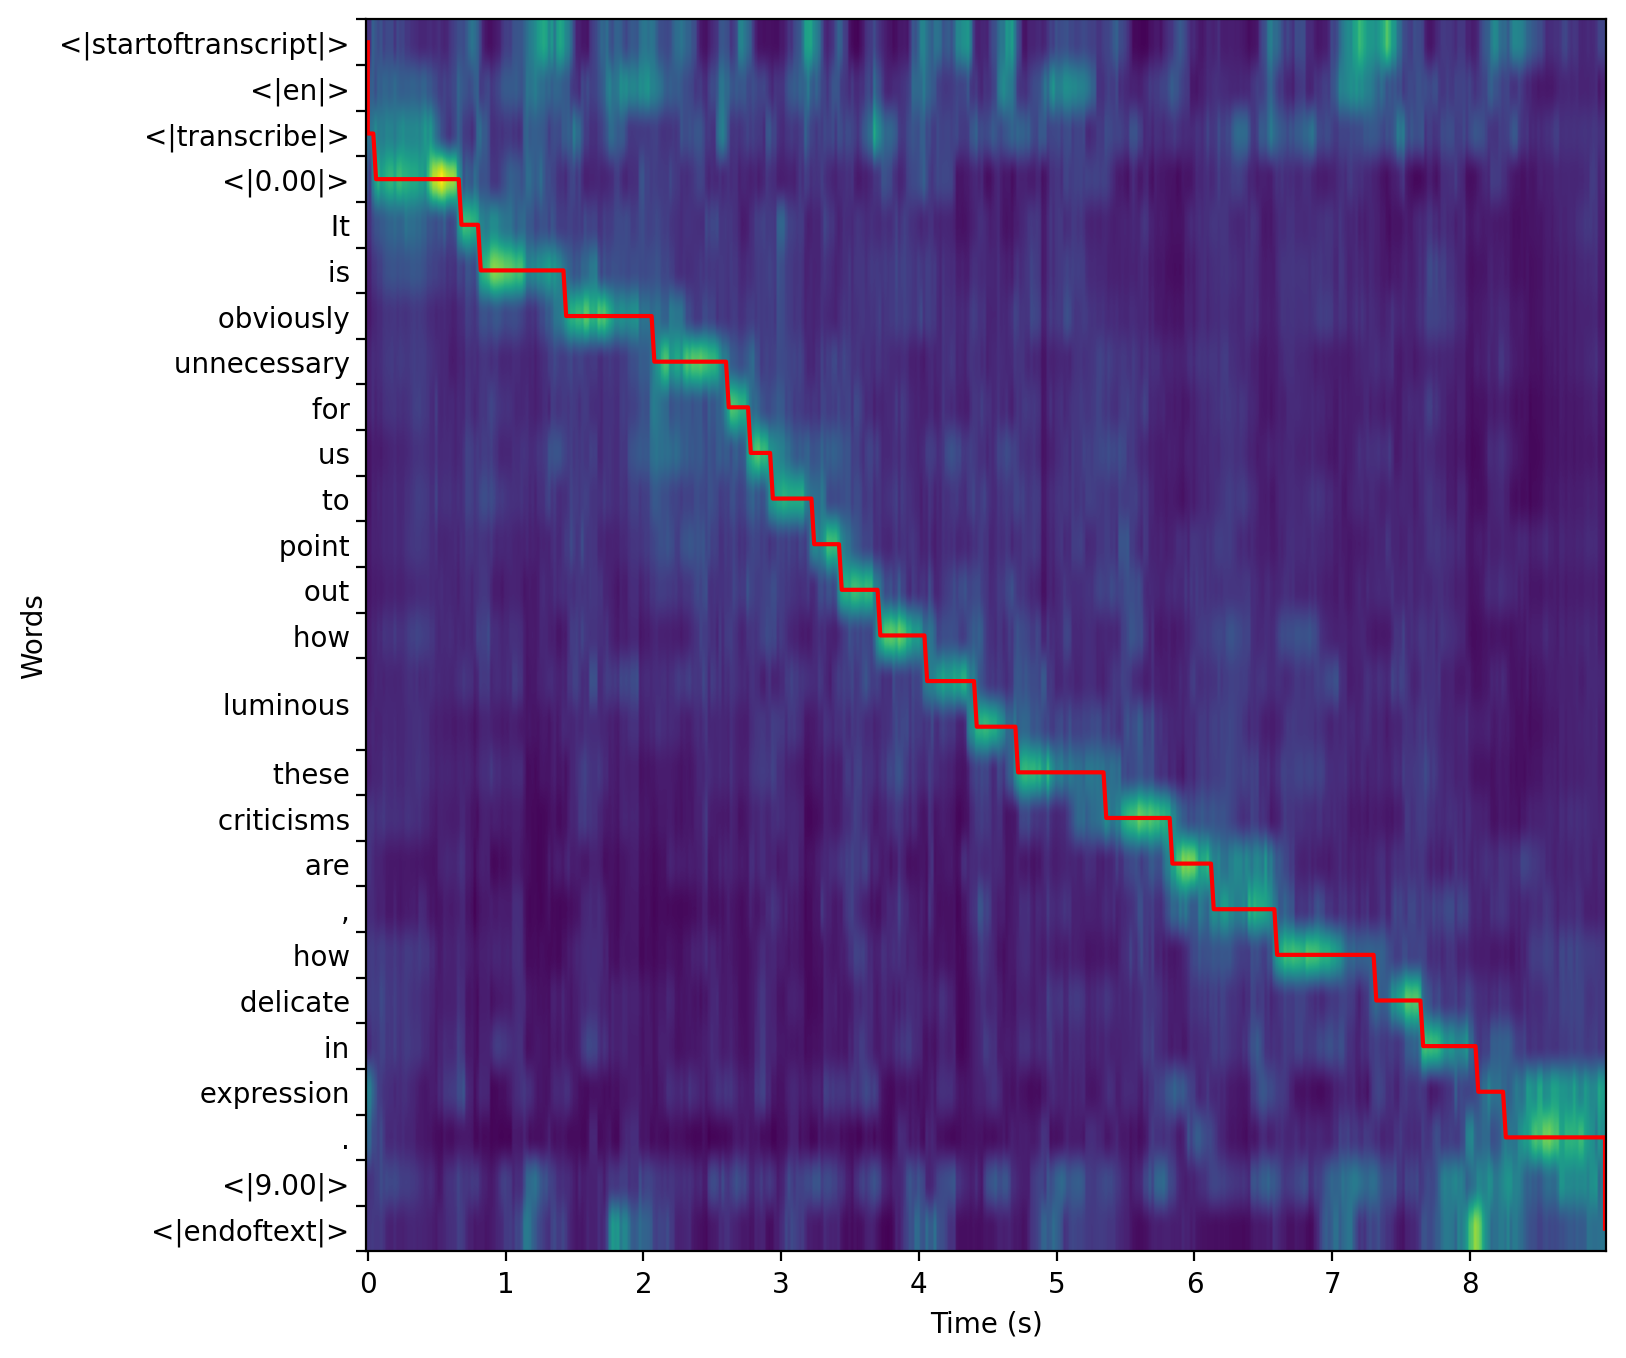

word  begin  w_begin   end  w_end
0             It   0.68     2.46  0.82   2.58
1             is   0.82     2.68  1.44   2.74
2      obviously   1.44     2.82  2.08   2.88
3    unnecessary   2.08     3.00  2.62   3.24
4            for   2.62     3.34  2.78   3.44
5             us   2.78     3.54  2.94   3.68
6             to   2.94     3.84  3.24   4.34
7          point   3.24     4.46  3.44   4.68
8            out   3.44     4.80  3.72   5.48
9            how   3.72     5.78  4.06   5.88
10      luminous   4.06     6.42  4.72   6.56
11         these   4.72     6.90  5.36   7.44
12    criticisms   5.36     7.58  5.84   7.62
13           are   5.84     7.70  6.14   8.34

 On the general principles of art, Mr. Crilter writes with equal lucidity.


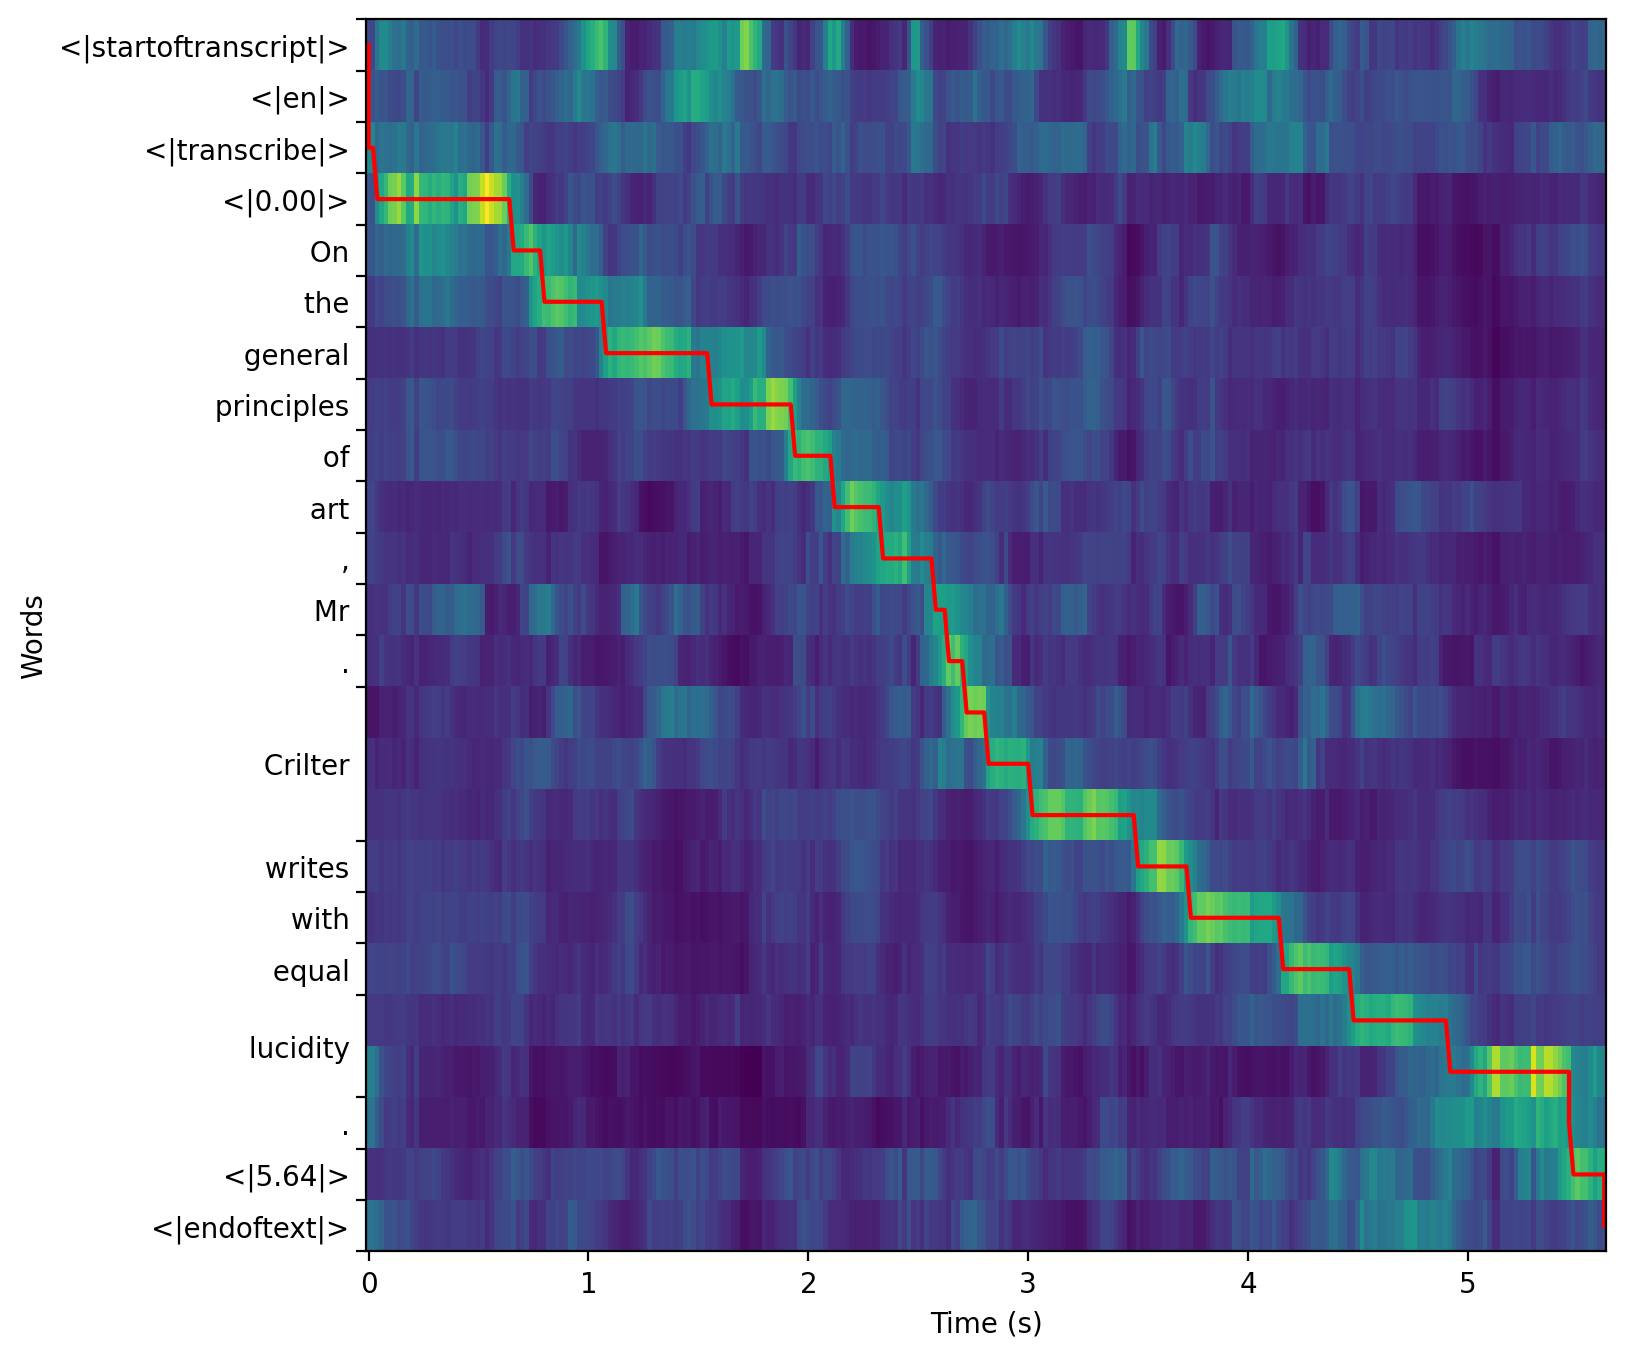

word  begin  w_begin   end  w_end
0           On   0.66     1.84  0.80   1.88
1          the   0.80     2.00  1.08   2.14
2      general   1.08     2.36  1.56   2.56
3   principles   1.56     2.62  1.94   3.00
4           of   1.94     3.28  2.12   3.52
5          art   2.12     3.60  2.34   3.72
6           Mr   2.58     4.28  2.64   4.96

 Painting, he tells us, is of a different quality to mathematics, and finish in art is adding more fact.


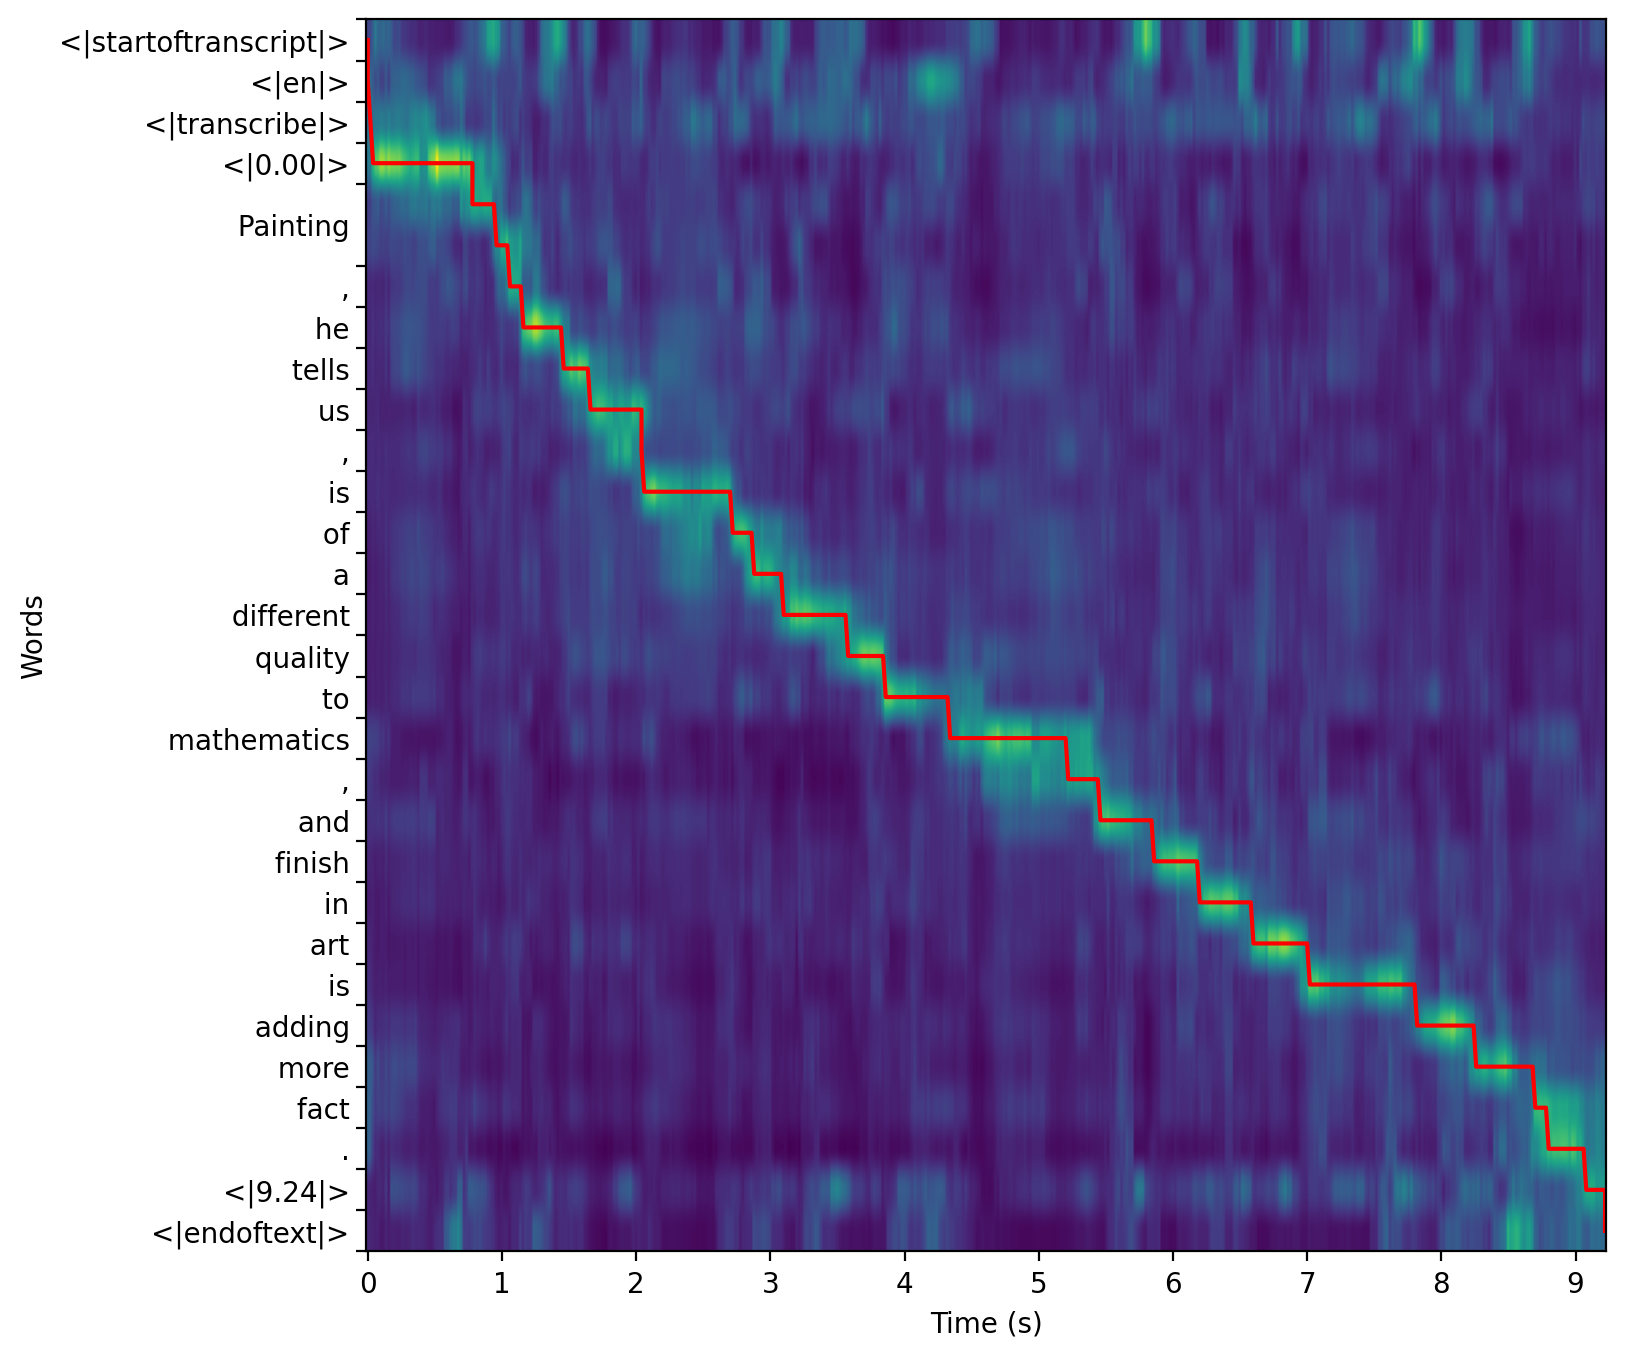

word  begin  w_begin   end  w_end
0       Painting   0.78     1.92  1.06   2.00
1             he   1.16     2.78  1.46   2.80
2          tells   1.46     2.86  1.66   3.14
3             us   1.66     3.22  2.04   3.66
4             is   2.06     3.92  2.72   4.56
5             of   2.72     5.34  2.88   5.42
6              a   2.88     5.52  3.10   5.82
7      different   3.10     6.12  3.58   6.16
8        quality   3.58     6.40  3.86   6.54
9             to   3.86     6.82  4.34   6.92
10   mathematics   4.34     7.58  5.22   7.86
11           and   5.46     8.42  5.86   8.68

 As for etchings, they are of two kinds, British and foreign.


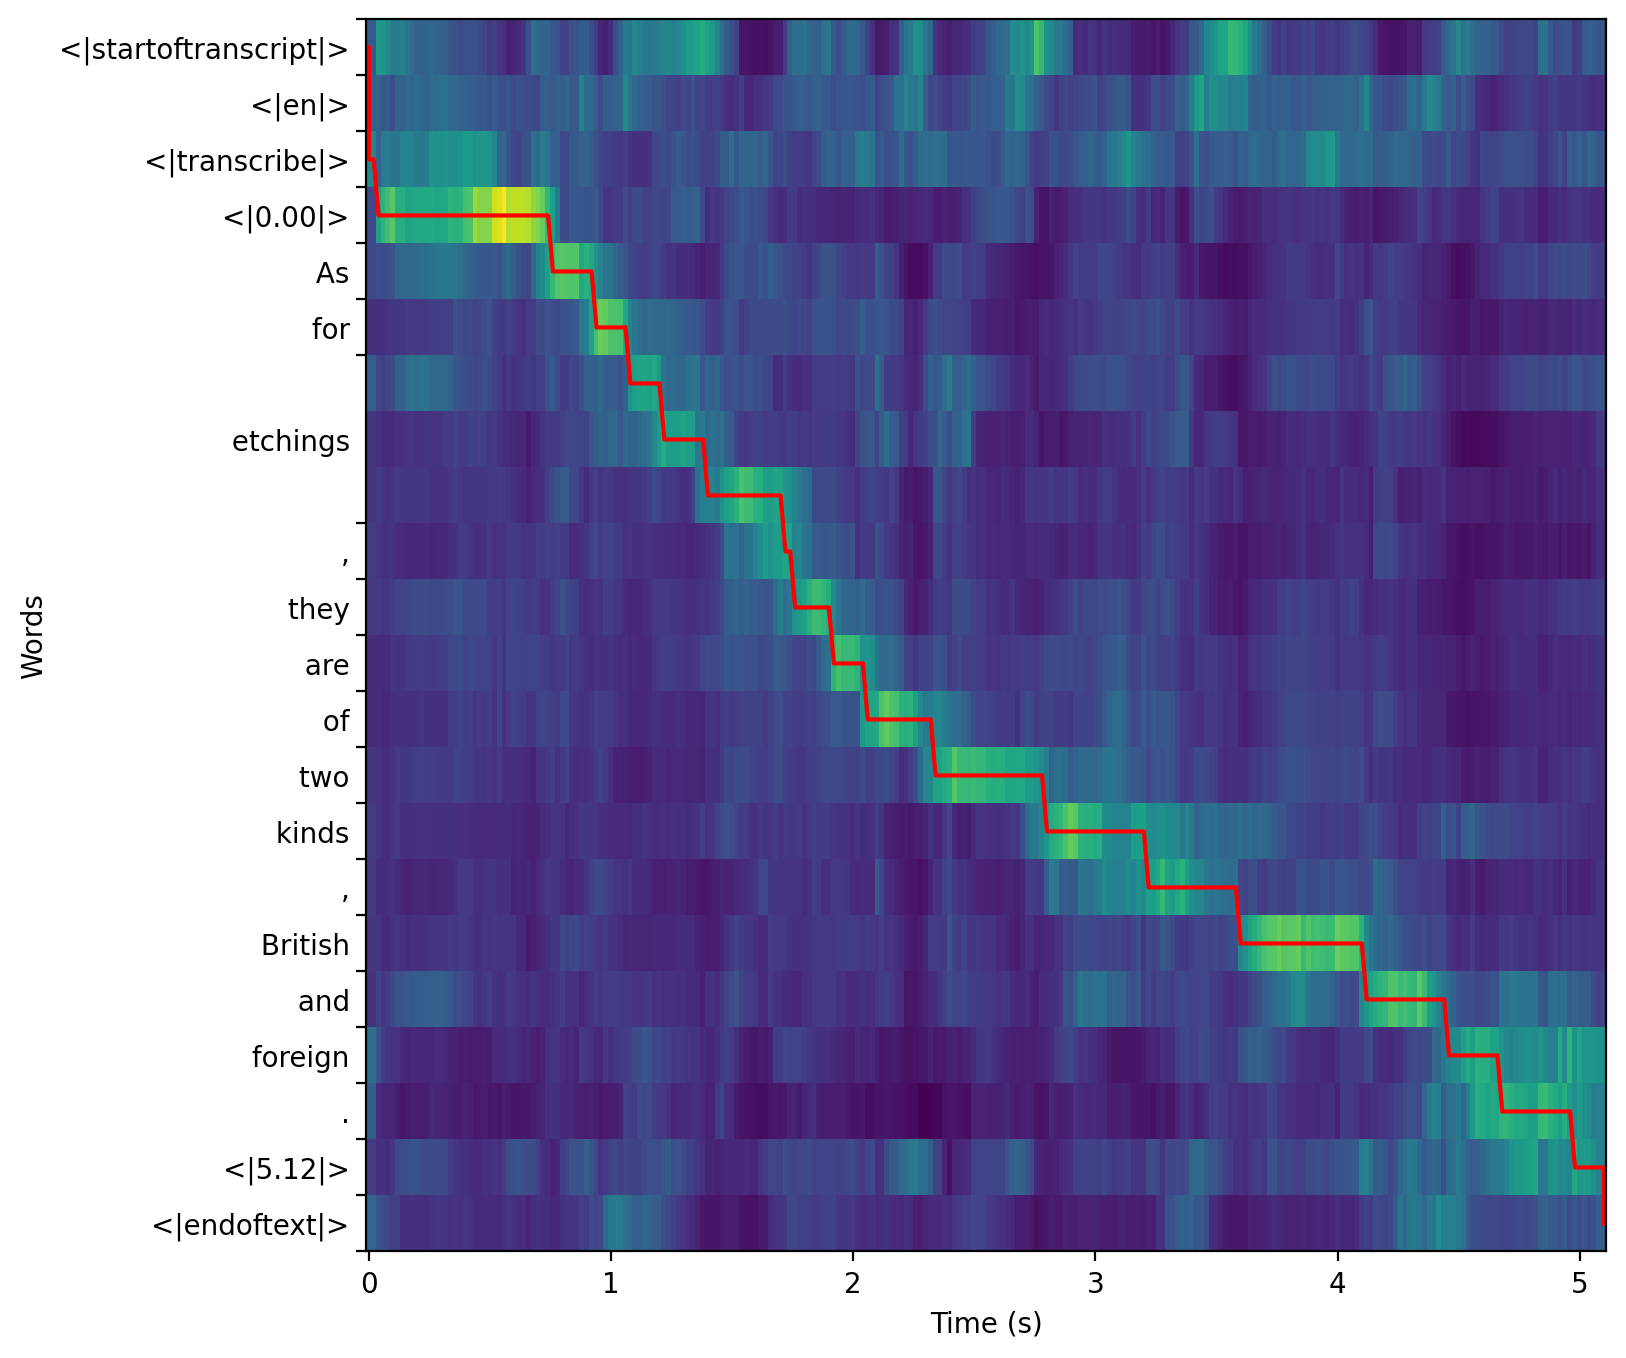

word  begin  w_begin   end  w_end
0         As   0.76     1.82  0.94   1.90
1        for   0.94     1.94  1.08   2.00
2   etchings   1.08     2.12  1.72   2.26
3       they   1.76     3.26  1.92   3.56
4        are   1.92     4.04  2.06   4.12
5         of   2.06     4.22  2.34   4.54

 he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures makes a customary appeal to the last judgment and reminds us that in the great days of art michael angelo was the furnishing upholsterer


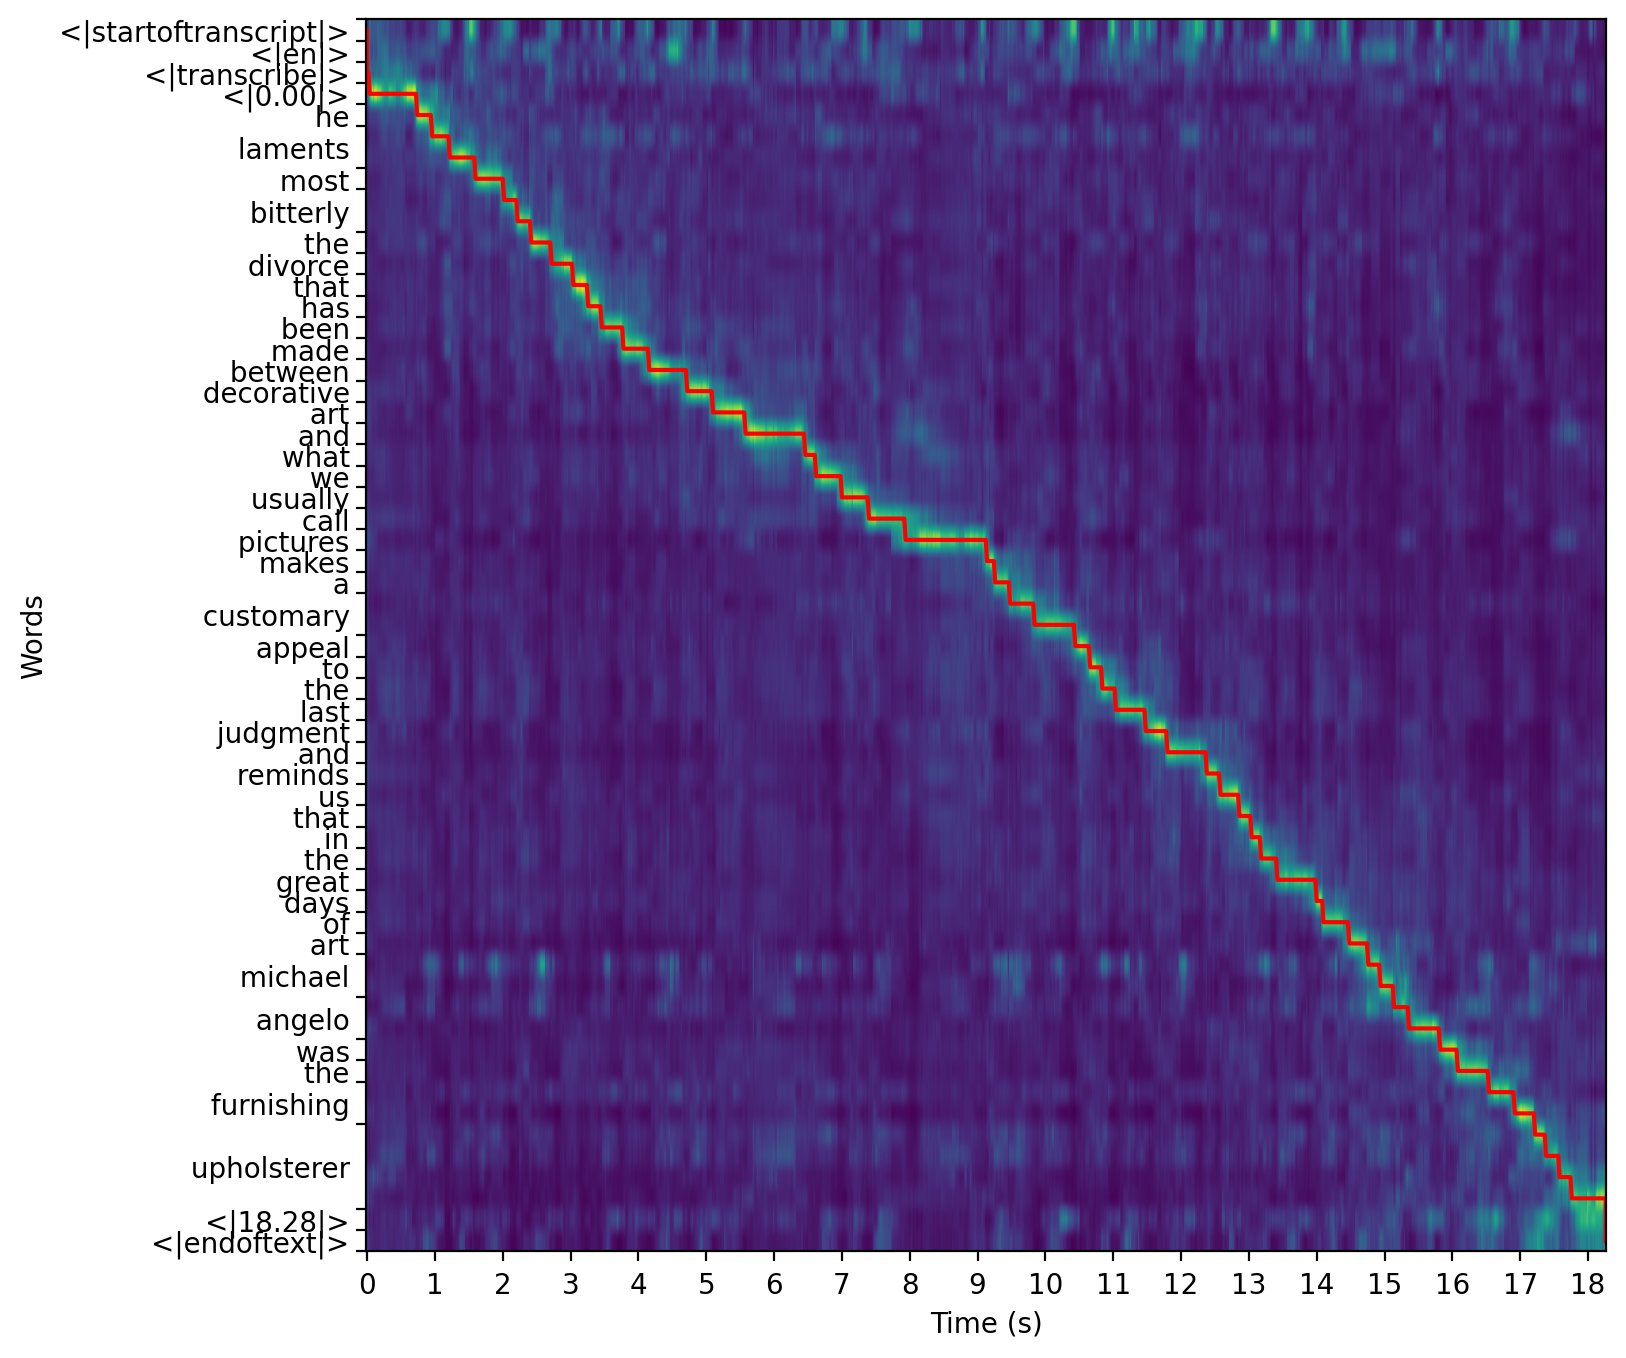

word  begin  w_begin    end  w_end
0            he   0.74     2.32   0.96   2.40
1       laments   0.96     2.46   1.60   2.84
2          most   1.60     2.92   2.02   3.04
3      bitterly   2.02     3.10   2.42   3.20
4           the   2.42     3.32   2.72   3.48
5       divorce   2.72     3.52   3.04   3.76
6          that   3.04     3.86   3.26   4.20
7           has   3.26     4.32   3.46   4.76
8          been   3.46     4.98   3.78   5.10
9          made   3.78     5.42   4.16   5.54
10      between   4.16     6.34   4.72   6.46
11   decorative   4.72     6.52   5.10   6.60
12          art   5.10     6.78   5.58   7.08
13          and   5.58     7.16   6.46   7.38
14         what   6.46     7.52   6.62   8.00
15           we   6.62     8.94   7.00   9.12
16      usually   7.00     9.20   7.40   9.22
17         call   7.40     9.26   7.94   9.90
18     pictures   7.94    10.10   9.14  10.46
19        makes   9.14    10.54   9.26  10.62
20            a   9.26    10.68   9.48  10.76
21    customary   9.48    10.82  10.44  11.04
22       appeal  10.44    11.14  10.66  11.58
23           to  10.66    11.72  10.84  11.78
24          the  10.84    11.86  11.04  12.32
25         last  11.04    12.46  11.48  12.54
26     judgment  11.48    12.68  11.80  12.84
27          and  11.80    12.96  12.38  13.02
28      reminds  12.38    13.08  12.58  13.16
29           us  12.58    13.20  12.86  13.40
30         that  12.86    13.62  13.04  13.92
31           in  13.04    14.02  13.18  14.06
32          the  13.18    14.30  13.42  14.44
33        great  13.42    14.62  14.00  14.92
34         days  14.00    15.02  14.10  15.40
35           of  14.10    15.64  14.48  15.80
36          art  14.48    15.90  14.76  16.04
37      michael  14.76    16.40  15.14  16.92
38       angelo  15.14    17.12  15.82  17.72

In [94]:
# for the first 10 examples in the dataset
for batch, transcription in zip(dataset.select(range(10)), transcriptions[:10]):
    print(transcription)

    audio = batch["audio"]["array"]
    audio = torch.from_numpy(audio).float()
    label = batch["text"]
  
    duration = len(audio)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio), n_mels=128).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ).cuda()
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.stack([QKs[_l][0:1, _h] for _l, _h in alignment_heads.indices().T]) 
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    # for label in ax.get_yminorticklabels():
    #     label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    chunks = pipe(batch["audio"]["array"], return_timestamps="word")["chunks"]
    w_begin_times = [chunk["timestamp"][0] for chunk in chunks]
    w_end_times = [chunk["timestamp"][1] for chunk in chunks]

    data = [
        dict(word=word, begin=begin, w_begin=w_begin, end=end, w_end=w_end)
        for word, begin, end, w_begin, w_end in zip(words[:-1], begin_times, end_times, w_begin_times, w_end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))

In [73]:
Audio(batch["audio"]["array"], rate=16_000)

In [75]:
pipe(batch["audio"]["array"], return_timestamps="word")

{'text': 'WHEN YOU CALL SOME ONE WHO IS THOUSANDS OF MILES AWAY YOU ARE USING A SATELLITE',
 'chunks': [{'text': 'WHEN', 'timestamp': (1.12, 1.24)},
  {'text': 'YOU', 'timestamp': (1.28, 1.36)},
  {'text': 'CALL', 'timestamp': (1.44, 1.64)},
  {'text': 'SOME', 'timestamp': (1.72, 1.88)},
  {'text': 'ONE', 'timestamp': (2.02, 2.12)},
  {'text': 'WHO', 'timestamp': (2.24, 2.34)},
  {'text': 'IS', 'timestamp': (2.44, 2.5)},
  {'text': 'THOUSANDS', 'timestamp': (2.58, 3.0)},
  {'text': 'OF', 'timestamp': (3.08, 3.12)},
  {'text': 'MILES', 'timestamp': (3.2, 3.44)},
  {'text': 'AWAY', 'timestamp': (3.5, 3.76)},
  {'text': 'YOU', 'timestamp': (4.3, 4.38)},
  {'text': 'ARE', 'timestamp': (4.44, 4.52)},
  {'text': 'USING', 'timestamp': (4.62, 4.82)},
  {'text': 'A', 'timestamp': (4.86, 4.9)},
  {'text': 'SATELLITE', 'timestamp': (4.98, 5.5)}]}